### Importing libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly as ply

# Preprocessing module
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder

# Tuners
from sklearn.utils import class_weight
from sklearn.model_selection import train_test_split, GridSearchCV

# Classifiers
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import BernoulliNB, MultinomialNB, GaussianNB
from sklearn.ensemble import AdaBoostClassifier
from xgboost import XGBClassifier

# Metrics modules
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import confusion_matrix
from sklearn.metrics import log_loss
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

import shap

import dill

In [2]:
# found out this lets pandas to display all columns in a dataframe
pd.set_option('display.max_columns', None)

In [164]:
#dill.dump_session('final.db')

In [2]:
#dill.load_session('final.db')

### A bunch of functions I've used for the project.

In [3]:
# it is named lr_analysis, but it can actually be used for other classifiers as well. 

def lr_analysis(solver, x, y, modelname=''):
    solver.fit(x, y)
    model_score = solver.score(x, y)
    print('==============================================================================================================')
    print(f'Analysis of the Model {modelname} ')
    print('-------------------------------------------------------------------')

    print(f'- Model Score : {model_score}')
        
    model_pred = solver.predict(x) 
    model_soft_pred = solver.predict_proba(x)
    loss_func = log_loss(y, model_soft_pred)
    print(f'- Cost Function: {loss_func}')
    print('\n')
    print(f'- Hard classification of the model {modelname}: {model_pred}')
    print(f'- Soft classfication of the model {modelname}: {model_soft_pred}')
    print('--------------------------------------------------------------------------------------------------------------')
    acc = accuracy_score(y, model_pred)
    pcs = precision_score(y, model_pred)
    rec = recall_score(y, model_pred)
    f1s = f1_score(y, model_pred)
        
    print(f'Classification metrics of the model {modelname}')
    print('- Accuracy: ', acc)
    print('- Precision: ', pcs)
    print('- Recall: ', rec)
    print('- F1 Score: ', f1s)
    print('==============================================================================================================')
    return model_soft_pred, model_score, model_pred, acc, pcs, rec, f1s

In [4]:
# Function for evaluating metrics only
 
def get_metrics(act, pred):
    print('Accuracy: ', accuracy_score(act, pred))
    print('Precision: ', precision_score(act, pred))
    print('Recall: ', recall_score(act, pred))
    print('F1 Score: ', f1_score(act, pred))
    return

In [83]:
# Plots a single ROC curve

def plot_roc(model_name, y_act, y_pred_prob):
    
    f = plt.figure()
    f.set_figwidth(12)
    f.set_figheight(7)
    
    fpr, tpr, thresholds = roc_curve(y_act, y_pred_prob[0][:,1])
    
    plt.plot(fpr, tpr, lw='5', color='navy')
    plt.plot([0,1], [0,1], color='red', ls='dashed', lw='1')

    plt.xlim([0,1])
    plt.ylim([0,1])
    plt.xlabel('FP')
    plt.ylabel('TP')
    plt.grid(ls=':', lw='0.5')
    
    plt.savefig(f'{model_name}.png')
    
    plt.show()
    
    print(f'ROC AUC for [{model_name}] model is: {roc_auc_score(y_act, y_pred_prob[0][:,1])}')
    return fpr, tpr, thresholds

In [6]:
# Just a function for plotting a simple confusion matrix

def testmodel_cm_maker(model, cm_threshold):
    cm_thr = model[0][:,1] >= cm_threshold
    cm = confusion_matrix(y_test, cm_thr)
    
    hm = sns.heatmap(cm, annot=True, cmap='Reds', fmt='d',
    xticklabels=['Paid In Full', 'Charged-off'],
    yticklabels=['Paid In Full', 'Charged-off'])
    hm.set(xlabel='Predicted', ylabel='Actual')

In [7]:
# Compares how much a model has improved(deteriorated) the prediction scores compared to another model 

def metric_comp(model1, model2, model1_name='Base Model',model2_name='Tuned Model'):
    
    model1_metrics = []
    model2_metrics = []
    
    for i in range(len(model1)):
        model1_metrics.append(model1[i])
    
    for i in range(len(model2)):
        model2_metrics.append(model2[i])
    
# Prints whole bunch of differences in metrics bet. two models. 
    print('======================================================================================================')
    print(f'Comparing model score of [{model2_name}] with the base model [{model1_name}] ')
    print('------------------------------------------------------------------------------------------------------')
    print(f'\u0394Score: {model2_metrics[1]-model1_metrics[1]}')
    print(f'\u0394Accuracy: {model2_metrics[3]-model1_metrics[3]}')
    print(f'\u0394Precision: {model2_metrics[4]-model1_metrics[4]}')
    print(f'\u0394Recall: {model2_metrics[5]-model1_metrics[5]}')
    print(f'\u0394F1: {model2_metrics[6]-model1_metrics[6]}')
    print('======================================================================================================')

# 1. EDA & Data Cleaning

#### -First of all, this is  what the names of each feature implies

Variable Name&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;Description <br>
LoanNr_ChkDgt&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;Identifier Primary key<br>
Name&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;Borrower name<br>
City&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;Borrower city<br>
State&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;Borrower state<br>
Zip&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;	Borrower zip code<br>
Bank&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;Bank name<br>
BankState&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;Bank state<br>
NAICS&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;North American industry classification system code<br>
ApprovalDate&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;Date SBA commitment issued<br>
ApprovalFY&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;Fiscal year of commitment<br>
Term&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;Loan term in months<br>
NoEmp&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;Number of business employees<br>
NewExist&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;1 = Existing business, 2 = New business<br>
CreateJob&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;Number of jobs created<br>
RetainedJob&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;Number of jobs retained<br>
FranchiseCode&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;Franchise code, (00000 or 00001) = No franchise<br>
UrbanRural&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;1 = Urban, 2 = rural, 0 = undefined<br>
RevLineCr&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;Revolving line of credit: Y = Yes, N = No<br>
LowDoc&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;LowDoc Loan Program: Y = Yes, N = No<br>
ChgOffDate&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;The date when a loan is declared to be in default<br>
DisbursementDate&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;Disbursement date<br>
DisbursementGross&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;Amount disbursed<br>
BalanceGross&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;Gross amount outstanding<br>
MIS_Status&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;Loan status charged off = CHGOFF, Paid in full =PIF<br>
ChgOffPrinGr&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;Charged-off amount<br>
GrAppv&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;Gross amount of loan approved by bank<br>
SBA_Appv&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;SBA’s guaranteed amount of approved loan<br>

In [13]:
sba = pd.read_csv('SBAnational.csv')

Columns (9) have mixed types.Specify dtype option on import or set low_memory=False.


In [14]:
sba_backup = sba.copy()

In [15]:
# In case of screw-up, run this code
#sba = sba_backup.copy()

In [16]:
sba_backup.sample(5)

,LoanNr_ChkDgt,Name,City,State,Zip,Bank,BankState,NAICS,ApprovalDate,ApprovalFY,Term,NoEmp,NewExist,CreateJob,RetainedJob,FranchiseCode,UrbanRural,RevLineCr,LowDoc,ChgOffDate,DisbursementDate,DisbursementGross,BalanceGross,MIS_Status,ChgOffPrinGr,GrAppv,SBA_Appv
520884,5041905000,"MD ENT, INC",MANHATTAN,KS,66502,COMMUNITY FIRST NATIONAL BANK,KS,492110,19-Jan-12,2012,18,1,2.0,0,1,0,2,N,N,NaN,19-Jan-12,"$10,500.00",$0.00,P I F,$0.00,"$10,500.00","$5,250.00"
357087,3488184010,BASKINS ROBBINS,BALTIMORE,MD,21234,REGAL BANK & TRUST,MD,0,21-Dec-99,2000,84,3,2.0,0,0,1,1,0,Y,NaN,30-Sep-00,"$60,000.00",$0.00,P I F,$0.00,"$60,000.00","$48,000.00"
263183,2841714000,GREGORY MARKETING CORP.,SAN ANTONIO,TX,78217,JEFFERSON BANK,TX,0,18-Mar-99,1999,60,6,1.0,0,0,1,0,0,Y,NaN,30-Jun-99,"$120,000.00",$0.00,P I F,$0.00,"$120,000.00","$90,000.00"
277552,2927205008,E & L Multisales Distribution,MIAMI,FL,33145,BANK OF AMERICA NATL ASSOC,NC,423920,29-Jan-08,2008,42,7,1.0,0,7,0,1,N,N,20-Oct-09,29-Feb-08,"$50,000.00",$0.00,CHGOFF,"$40,835.00","$50,000.00","$25,000.00"
249918,2758856009,CHARLES LATZKE,GAYLORD,MN,55334,KLEINBANK,MN,611110,17-Apr-07,2007,7,2,1.0,3,2,1,2,0,N,20-Feb-14,31-May-07,"$59,800.00",$0.00,CHGOFF,"$20,152.00","$59,800.00","$50,830.00"


In [17]:
sba['ApprovalFY'] = pd.to_datetime(sba['ApprovalFY'].astype(str), errors='coerce')
sba['ApprovalDate'] = pd.to_datetime(sba['ApprovalDate'].astype(str), errors='coerce')

In [18]:
sba.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 899164 entries, 0 to 899163
Data columns (total 27 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   LoanNr_ChkDgt      899164 non-null  int64         
 1   Name               899150 non-null  object        
 2   City               899134 non-null  object        
 3   State              899150 non-null  object        
 4   Zip                899164 non-null  int64         
 5   Bank               897605 non-null  object        
 6   BankState          897598 non-null  object        
 7   NAICS              899164 non-null  int64         
 8   ApprovalDate       899164 non-null  datetime64[ns]
 9   ApprovalFY         899146 non-null  datetime64[ns]
 10  Term               899164 non-null  int64         
 11  NoEmp              899164 non-null  int64         
 12  NewExist           899028 non-null  float64       
 13  CreateJob          899164 non-null  int64   

## Cleaning the data

### The data is pretty big. First, I am going to check whether null values exist.
- Note: Charge-off Date must be made an exception because loans that were paid in full have null values for ChgOffDate

In [19]:
pd.isna(sba).sum()

LoanNr_ChkDgt             0
Name                     14
City                     30
State                    14
Zip                       0
Bank                   1559
BankState              1566
NAICS                     0
ApprovalDate              0
ApprovalFY               18
Term                      0
NoEmp                     0
NewExist                136
CreateJob                 0
RetainedJob               0
FranchiseCode             0
UrbanRural                0
RevLineCr              4528
LowDoc                 2582
ChgOffDate           736465
DisbursementDate       2368
DisbursementGross         0
BalanceGross              0
MIS_Status             1997
ChgOffPrinGr              0
GrAppv                    0
SBA_Appv                  0
dtype: int64

There are tons of NaNs! Dropping all the rows that have missing values for any of the following columns.

In [20]:
sba = sba.dropna(subset=['Name', 'City', 'State', 'Bank',
                   'BankState', 'ApprovalFY', 'NewExist', 'RevLineCr',
                   'LowDoc', 'DisbursementDate', "MIS_Status"])

In [21]:
#Checking that the missing values, with the charge off date as an exception, are succcesfully dropped.
pd.isna(sba).sum()

LoanNr_ChkDgt             0
Name                      0
City                      0
State                     0
Zip                       0
Bank                      0
BankState                 0
NAICS                     0
ApprovalDate              0
ApprovalFY                0
Term                      0
NoEmp                     0
NewExist                  0
CreateJob                 0
RetainedJob               0
FranchiseCode             0
UrbanRural                0
RevLineCr                 0
LowDoc                    0
ChgOffDate           725369
DisbursementDate          0
DisbursementGross         0
BalanceGross              0
MIS_Status                0
ChgOffPrinGr              0
GrAppv                    0
SBA_Appv                  0
dtype: int64

Now I will drop the columns that seem  unimportant for this analysis.

In [22]:
# Note: if you have time, add your rationales for dropping said columns

sba = sba.drop(['LoanNr_ChkDgt', 'Name', 'Bank',
                'BankState', 'ChgOffDate', 'DisbursementDate', 
                'BalanceGross','ChgOffPrinGr'], axis=1)

In [23]:
sba.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 886225 entries, 0 to 899163
Data columns (total 19 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   City               886225 non-null  object        
 1   State              886225 non-null  object        
 2   Zip                886225 non-null  int64         
 3   NAICS              886225 non-null  int64         
 4   ApprovalDate       886225 non-null  datetime64[ns]
 5   ApprovalFY         886225 non-null  datetime64[ns]
 6   Term               886225 non-null  int64         
 7   NoEmp              886225 non-null  int64         
 8   NewExist           886225 non-null  float64       
 9   CreateJob          886225 non-null  int64         
 10  RetainedJob        886225 non-null  int64         
 11  FranchiseCode      886225 non-null  int64         
 12  UrbanRural         886225 non-null  int64         
 13  RevLineCr          886225 non-null  object  

In [24]:
sba_backup2 = sba.copy()
#sba = sba_backup2

### Some manipulations on columns with monetary values

In [25]:
# Removing commas

sba['GrAppv'] = sba['GrAppv'].str.replace(',', '', regex=False)
sba['SBA_Appv'] = sba['SBA_Appv'].str.replace(',', '', regex=False)
sba['DisbursementGross'] = sba['DisbursementGross'].str.replace(',', '', regex=False)

# Removing $ signs
sba['GrAppv'] = sba['GrAppv'].str.replace('$', '', regex=False)
sba['SBA_Appv'] = sba['SBA_Appv'].str.replace('$', '', regex=False)
sba['DisbursementGross'] = sba['DisbursementGross'].str.replace('$', '', regex=False)

# Converting dtype into float
sba['GrAppv'] = sba['GrAppv'].astype('float64')
sba['SBA_Appv'] = sba['SBA_Appv'].astype('float64')
sba['DisbursementGross'] = sba['DisbursementGross'].astype('float64')

In [26]:
sba.sample(5)

,City,State,Zip,NAICS,ApprovalDate,ApprovalFY,Term,NoEmp,NewExist,CreateJob,RetainedJob,FranchiseCode,UrbanRural,RevLineCr,LowDoc,DisbursementGross,MIS_Status,GrAppv,SBA_Appv
761740,WEST SPRINGFIELD,PA,16443,0,1995-01-12,1995-01-01,36,2,2.0,0,0,1,0,N,Y,12000.0,P I F,12000.0,10800.0
237316,SHELLEY,ID,83274,238220,2007-09-04,2007-01-01,84,1,2.0,0,1,0,1,Y,N,53049.0,P I F,35000.0,17500.0
546587,MIDLAND,TX,79701,811122,1992-12-02,1993-01-01,72,5,1.0,0,0,1,0,N,N,126384.0,P I F,126384.0,109954.0
455011,HOUSTON,TX,77084,811111,1991-03-19,1991-01-01,216,6,1.0,0,0,1,0,N,N,135000.0,P I F,135000.0,121500.0
640385,COVINGTON,VA,24426,621310,2003-06-06,2003-01-01,120,2,1.0,0,2,1,2,0,N,227200.0,P I F,227200.0,170400.0


### Now that rows with NaN are removed, I am checking for any peculiar entry in categorical features:

In [27]:
print(f'Entries for NewExist: {sba.NewExist.unique()}')
print(f'Entries for RevLineCr: {sba.RevLineCr.unique()}')
print(f'Entries for LowDoc: {sba.LowDoc.unique()}')
print(f'Entries for UrbanRural: {sba.UrbanRural.unique()}')
print(f'Entries for MIS_Status: {sba.MIS_Status.unique()}')

Entries for NewExist: [2. 1. 0.]
Entries for RevLineCr: ['N' '0' 'Y' 'T' '`' ',' '1' 'C' '3' '2' 'R' '7' 'A' '5' '.' '4' '-' 'Q']
Entries for LowDoc: ['Y' 'N' 'C' '1' 'S' 'R' 'A' '0']
Entries for UrbanRural: [0 1 2]
Entries for MIS_Status: ['P I F' 'CHGOFF']


Ok.. for RevLineCr and LowDoc the entries are supposed to be either Y or N... some weird-arse values out there...
<br>Also, NewExist is supposed to be either 1 or 2, but it also has 0 and nan. should get rid of these, too.

Removing all rows with those weird values

In [28]:
# Selects all the rows with values other than Y and N, then drop them from the main dataset.

rev_drop = sba[sba['RevLineCr'].isin(['0','T', '`', ',', '1', 'C', '3', '2', 'R', '7', 'A', '5', '.', '4', '-', 'Q'])].index
sba = sba.drop(rev_drop)

ld_drop = sba[sba['LowDoc'].isin(['C', '1', 'S', 'R', 'A', '0'])].index
sba = sba.drop(ld_drop)

In [29]:
# Check if the weird values were successfully dropped

print(sba['RevLineCr'].unique())
print(sba['LowDoc'].unique())


['N' 'Y']
['Y' 'N']


In [30]:
sba = sba.reset_index(drop=True)

In [31]:
sba['NewExist'] = sba['NewExist'].astype(float)
sba['NewExist'] = sba['NewExist'].astype(int)

In [32]:
# Cleaning NewExist column: removing all the rows with '0'
newexist_to_drop = sba[sba['NewExist'].isin([0, 'nan'])].index
sba = sba.drop(newexist_to_drop)

In [33]:
print(sba['NewExist'].unique())

[2 1]


In [34]:
sba.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 610172 entries, 0 to 611124
Data columns (total 19 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   City               610172 non-null  object        
 1   State              610172 non-null  object        
 2   Zip                610172 non-null  int64         
 3   NAICS              610172 non-null  int64         
 4   ApprovalDate       610172 non-null  datetime64[ns]
 5   ApprovalFY         610172 non-null  datetime64[ns]
 6   Term               610172 non-null  int64         
 7   NoEmp              610172 non-null  int64         
 8   NewExist           610172 non-null  int32         
 9   CreateJob          610172 non-null  int64         
 10  RetainedJob        610172 non-null  int64         
 11  FranchiseCode      610172 non-null  int64         
 12  UrbanRural         610172 non-null  int64         
 13  RevLineCr          610172 non-null  object  

### Some additional data manipulation

Adds a new column called bank_vs_sba. This checks whether banks were willing to  lend more loan than the amount SBA has approved.
<br> Is there any case where the bank approved LESS than SBA did?

In [35]:
sba['bvs'] = (sba['GrAppv']-sba['SBA_Appv'])

#Check to see if there is any case where bank approved less than that of sba.
print((sba['bvs'].values < 0).any())

False


So, no banks have ever approved less than SBA. This must be true, because SBA approved amount is the minimum guarenteed amount that a business can borrow. Otherwise, the corresponding entry would've been wrong and thus had to be removed. Fortunately, no such case exists.
<br>
<br>Below creates a new column that checks, for each company, whether the bank handed greater amount of loan than SBA did.
 - 1 : Bank Approval > SBA Approval,  0: Bank Approval = SBA Approval

In [36]:
sba['more_than_sba'] = np.where(sba['bvs'] > 0.0, '1', '0')

In [37]:
sba['more_than_sba'] = sba['more_than_sba'].astype(str).astype(int)

### For the last time, let's check again the cleaned dataset for any NaN

In [38]:
pd.isna(sba).sum()

City                 0
State                0
Zip                  0
NAICS                0
ApprovalDate         0
ApprovalFY           0
Term                 0
NoEmp                0
NewExist             0
CreateJob            0
RetainedJob          0
FranchiseCode        0
UrbanRural           0
RevLineCr            0
LowDoc               0
DisbursementGross    0
MIS_Status           0
GrAppv               0
SBA_Appv             0
bvs                  0
more_than_sba        0
dtype: int64

In [39]:
sba.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 610172 entries, 0 to 611124
Data columns (total 21 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   City               610172 non-null  object        
 1   State              610172 non-null  object        
 2   Zip                610172 non-null  int64         
 3   NAICS              610172 non-null  int64         
 4   ApprovalDate       610172 non-null  datetime64[ns]
 5   ApprovalFY         610172 non-null  datetime64[ns]
 6   Term               610172 non-null  int64         
 7   NoEmp              610172 non-null  int64         
 8   NewExist           610172 non-null  int32         
 9   CreateJob          610172 non-null  int64         
 10  RetainedJob        610172 non-null  int64         
 11  FranchiseCode      610172 non-null  int64         
 12  UrbanRural         610172 non-null  int64         
 13  RevLineCr          610172 non-null  object  

### Now that I have cleaned the data, I will encode categorical features

Most of the cat. features are binary, so I won't use onehotencoder here

In [40]:
le = LabelEncoder()

In [41]:
# Adding the encoded States column to the DF
sba['State_coded'] = le.fit_transform(sba['State'])

In [42]:
# Adding the encoded Revolving Line of Credit column to the DF
sba['RevLineCr_coded'] = le.fit_transform(sba['RevLineCr'])

In [43]:
# Adding the encoded Low Documentation Loan column to the DF
sba['LowDoc_coded'] = le.fit_transform(sba['LowDoc'])

In [44]:
# Adding the encoded payoff status column to the DF
sba['MIS_Status_coded'] = le.fit_transform(sba['MIS_Status'])

In [45]:
sba.sample(5)

,City,State,Zip,NAICS,ApprovalDate,ApprovalFY,Term,NoEmp,NewExist,CreateJob,RetainedJob,FranchiseCode,UrbanRural,RevLineCr,LowDoc,DisbursementGross,MIS_Status,GrAppv,SBA_Appv,bvs,more_than_sba,State_coded,RevLineCr_coded,LowDoc_coded,MIS_Status_coded
291473,DALLAS,GA,30132,0,2000-09-01,2000-01-01,84,1,2,0,0,1,1,N,N,150000.0,P I F,150000.0,112500.0,37500.0,1,10,0,0,1
167039,MILWAUKEE,WI,53214,561730,2007-06-20,2007-01-01,84,4,1,0,4,0,1,N,N,17400.0,P I F,17400.0,8700.0,8700.0,1,48,0,0,1
273454,BILLINGS,MT,59108,235110,2000-03-20,2000-01-01,12,4,1,0,0,1,1,Y,N,141004.0,P I F,130000.0,97500.0,32500.0,1,26,1,0,1
27545,INDIANAPOLIS,IN,46236,541410,2005-04-06,2005-01-01,34,1,1,0,1,1,2,Y,N,9555.0,CHGOFF,5000.0,2500.0,2500.0,1,15,1,0,0
4449,BALLWIN,MO,63021,238350,2004-08-13,2004-01-01,50,7,1,0,0,1,1,N,N,50000.0,CHGOFF,50000.0,25000.0,25000.0,1,24,0,0,0


- Maybe I gotta stratify the data...

In [46]:
print(f'Total count of Paid-in-fulls: {len(sba[sba.MIS_Status_coded == 1])}')
print(f'Total count of Charge-offs (defaults): {len(sba[sba.MIS_Status_coded == 0])}')

Total count of Paid-in-fulls: 499634
Total count of Charge-offs (defaults): 110538


Exporting the cleaned-up data to csv

In [47]:
sba.to_csv('sba_cleaned.csv', encoding = 'utf-8-sig') 

# 2. Building Models

Import cleaned dataset from EDA

In [48]:
sba = pd.read_csv('sba_cleaned.csv', index_col = 0)

In [49]:
print(sba.shape)
sba.sample(4)

(610172, 25)


,City,State,Zip,NAICS,ApprovalDate,ApprovalFY,Term,NoEmp,NewExist,CreateJob,RetainedJob,FranchiseCode,UrbanRural,RevLineCr,LowDoc,DisbursementGross,MIS_Status,GrAppv,SBA_Appv,bvs,more_than_sba,State_coded,RevLineCr_coded,LowDoc_coded,MIS_Status_coded
297721,BUFFALO,NY,14240,0,1990-04-05,1990-01-01,60,78,1,0,0,1,0,N,N,1000000.0,P I F,1000000.0,750000.0,250000.0,1,34,0,0,1
534844,HORSEHEADS,NY,14845,233210,1995-04-04,1995-01-01,4,4,1,0,0,1,0,N,N,20800.0,P I F,20800.0,15600.0,5200.0,1,34,0,0,1
165506,WILLIAMSTON,NC,27892,238990,2007-06-13,2007-01-01,84,2,2,0,2,0,1,Y,N,15736.0,P I F,6000.0,3000.0,3000.0,1,27,1,0,1
393691,RIVERSIDE,CA,92503,448140,2002-05-06,2002-01-01,20,2,1,2,2,1,1,N,N,20000.0,CHGOFF,20000.0,10000.0,10000.0,1,4,0,0,0


###  Assigning features and a target
The target column here would be loan status of each business (labeled as <b>'MIS_Status_coded'</b>). <br>
Recall that the status has been coded as follows:
- If the business has fully paid the loan off (paid in full) = 1 <br>
- If the business has defaulted (charged off) = 0

In [50]:
# The target.  Note: 1= paid in full, 0 = charged off
y_sba = sba[['MIS_Status_coded']]

In [51]:
# Picking features for my model
X_sba = sba[['NoEmp', 'NewExist', 'CreateJob', 'RetainedJob', 'UrbanRural',
             'RevLineCr_coded', 'LowDoc_coded', 'DisbursementGross', 'more_than_sba']]

In [52]:
X_sba.columns

Index(['NoEmp', 'NewExist', 'CreateJob', 'RetainedJob', 'UrbanRural',
       'RevLineCr_coded', 'LowDoc_coded', 'DisbursementGross',
       'more_than_sba'],
      dtype='object')

In [53]:
#y_sba_backup = y_sba.copy()

I will try reassigning cat. values for the tartget

In [54]:
y_sba = pd.DataFrame(np.where(y_sba==1, 0, 1), columns=['MIS_Status_coded'])

In [55]:
y_sba

,MIS_Status_coded
0,0
1,0
2,0
3,0
4,0
...,...
610167,0
610168,0
610169,0
610170,1


### Splitting the dataset: Train-test-validate splitting (60:20:20)

In [56]:
X_train, X_test, y_train, y_test = train_test_split(X_sba, y_sba, test_size=0.2, random_state=123)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=123)

In [57]:
print(len(y_train[y_train.MIS_Status_coded == 1]))
print(len(y_train[y_train.MIS_Status_coded == 0]))

66456
299646


I might have to consider class imbalance  later on..?

# A. Log. Regression

### Since simple average of target distribution is pretty ridiculous to be used as a baseline at this point, I will go with plain, non-tuned LogReg model as a starting model.

- Setting up LogReg

In [58]:
# Just a default logreg.
logreg = LogisticRegression(random_state=123)

- Scaling the data

In [59]:
scaler = StandardScaler()

# Scaling Train Dataset
X_tr_scale = scaler.fit_transform(X_train)
y_train = y_train.values.ravel()

# Scaling Val. Dataset
X_val_scale = scaler.fit_transform(X_val)
y_val = y_val.values.ravel()

# Scaling Test Dataset
X_te_scale = scaler.fit_transform(X_test)
y_test = y_test.values.ravel()

### A-1. Fitting the train dataset

In [60]:
lr_base = lr_analysis(logreg, X_tr_scale, y_train, 'Baseline LogReg')

Analysis of the Model Baseline LogReg 
-------------------------------------------------------------------
- Model Score : 0.8188510305871042
- Cost Function: 0.43129825874054095


- Hard classification of the model Baseline LogReg: [0 0 0 ... 0 0 0]
- Soft classfication of the model Baseline LogReg: [[0.92439002 0.07560998]
 [0.73363087 0.26636913]
 [0.99314821 0.00685179]
 ...
 [0.7385272  0.2614728 ]
 [0.62476212 0.37523788]
 [0.6158018  0.3841982 ]]
--------------------------------------------------------------------------------------------------------------
Classification metrics of the model Baseline LogReg
- Accuracy:  0.8188510305871042
- Precision:  0.9858156028368794
- Recall:  0.0020916094859756832
- F1 Score:  0.004174362208507891


What happened to recall?

In [61]:
# Validation run of the 'baseline' logreg model
lr_val_base = lr_analysis(logreg, X_val_scale, y_val)

Analysis of the Model  
-------------------------------------------------------------------
- Model Score : 0.8202646781660999
- Cost Function: 0.42991138591259204


- Hard classification of the model : [0 0 0 ... 0 0 0]
- Soft classfication of the model : [[0.97925508 0.02074492]
 [0.73370784 0.26629216]
 [0.89953918 0.10046082]
 ...
 [0.84248948 0.15751052]
 [0.73464944 0.26535056]
 [0.8592492  0.1407508 ]]
--------------------------------------------------------------------------------------------------------------
Classification metrics of the model 
- Accuracy:  0.8202646781660999
- Precision:  0.9787234042553191
- Recall:  0.0020929068656444787
- F1 Score:  0.0041768818668845905


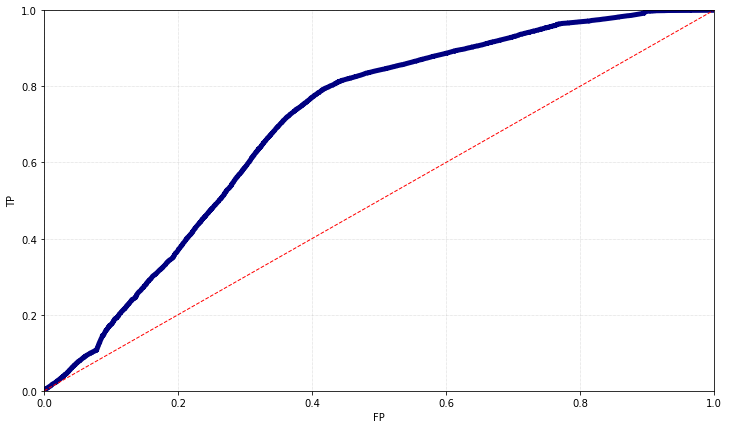

ROC AUC for [Baseline LogReg Model] model is: 0.7038953533853063


In [84]:
roc_lr_base = plot_roc('Baseline LogReg Model', y_val, lr_val_base)

### A-1a. Parameter estimates

Let's take a break from the machine learning and take a look at imoprtance of each parameter. <br>
Below will give the client some insight on which features they should focuse on when determining if a business is likely to default on them. 

In [63]:
coef_names = list(X_train.columns)

logreg_coefs = np.exp((logreg.coef_).tolist()[0])

logreg_coefs_tuple = list(zip(coef_names, logreg_coefs))
#param_est = pd.DataFrame(logreg_coefs_tuple, columns=['Feature', 'Coeff ("de-logged")'])
param_est = pd.DataFrame(logreg_coefs, index=coef_names, columns=['Coeff ("de-logged")'])

param_est['Importance'] = param_est['Coeff ("de-logged")']-1
print(param_est)

                   Coeff ("de-logged")  Importance
NoEmp                         0.755335   -0.244665
NewExist                      0.993113   -0.006887
CreateJob                     0.867588   -0.132412
RetainedJob                   1.260943    0.260943
UrbanRural                    1.482767    0.482767
RevLineCr_coded               0.989606   -0.010394
LowDoc_coded                  0.669859   -0.330141
DisbursementGross             0.661279   -0.338721
more_than_sba                 1.942945    0.942945


<br>
- Some insights:<br>
 -More the loan disbursed, more likey to pay off. <br>
 -Caveat, though, if a business end up getting more loans from the bank than the amount SBA has approved, the business is more likely to fail to pay the loan back. <br>
 -Rural businesses are at greater risk of defaulting than the urban ones. <br>
 -Biz. that applied for Low Documentation are more likely to pay them back <br>
 -Another interesting thing is whether the biz is new or not doesn't really play any role in it failling to pay back (coeff.~0.01, close to 0).

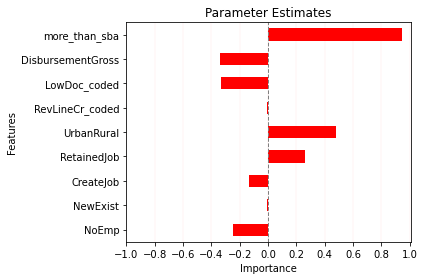

In [64]:
param_plot = param_est.plot.barh(y='Importance', color='red')
plt.xticks(np.arange(-1.0, 1.2, step=0.2))
param_plot.set_xlabel('Importance')
param_plot.set_ylabel('Features')
param_plot.xaxis.grid(color='red',lw='0.05', zorder=0)
plt.axvline(x = 0, color="gray", ls='--', lw='1')
param_plot.set_title('Parameter Estimates')
param_plot.get_legend().remove()
plt.tight_layout()
plt.savefig('feature_importance.png')

## A-2. Hyperparameter tuning, oversampling

Starting with tuning hyperparameters for 'baseline' LogReg model

In [65]:
logreg2 = LogisticRegression()

In [66]:
hyp_C = [10**i for i in range(-1, 5)]
lr_penalty =  ['l1', 'l2','elasticnet','none']
lr_weight = ['balanced', {1 : 1, 0 : 2},{1 : 1, 0 : 3},{1 : 1, 0 : 4}, {1 : 1, 0 : 5} ]
lr_solver = ['liblinear', 'lbfgs', 'newton-cg', 'saga']
lr_maxiter = [100, 200, 300]


param_grid_lr = {'C': hyp_C, 'class_weight': lr_weight, 'penalty': lr_penalty, 'solver':lr_solver, 'max_iter':lr_maxiter}


In [67]:
lr_Grid = GridSearchCV(estimator = logreg2, param_grid = param_grid_lr, cv=3, verbose=3, n_jobs = -2)

In [69]:
lr_Grid.fit(X_tr_scale, y_train)

Fitting 3 folds for each of 1440 candidates, totalling 4320 fits


C:\Users\Hyosang-PC\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:922: UserWarning: One or more of the test scores are non-finite: [0.60517561        nan        nan ... 0.59848348 0.59848348 0.59848621]
  warnings.warn(


GridSearchCV(cv=3, estimator=LogisticRegression(), n_jobs=-2,
             param_grid={'C': [0.1, 1, 10, 100, 1000, 10000],
                         'class_weight': ['balanced', {0: 2, 1: 1},
                                          {0: 3, 1: 1}, {0: 4, 1: 1},
                                          {0: 5, 1: 1}],
                         'max_iter': [100, 200, 300],
                         'penalty': ['l1', 'l2', 'elasticnet', 'none'],
                         'solver': ['liblinear', 'lbfgs', 'newton-cg', 'saga']},
             verbose=3)

In [201]:
lr_best_param = lr_Grid.best_params_
print(lr_best_param)

AttributeError: 'GridSearchCV' object has no attribute 'best_params_'

best parameters : {'C': 0.1, 'class_weight': {1: 1, 0: 2}, 'penalty': 'l1', 'solver': 'saga'}

In [82]:
dill.dumps(lr_best_param)

b'\x80\x04\x95^\x00\x00\x00\x00\x00\x00\x00}\x94(\x8c\x01C\x94G?\xb9\x99\x99\x99\x99\x99\x9a\x8c\x0cclass_weight\x94}\x94(K\x01K\x01K\x00K\x02u\x8c\x08max_iter\x94Kd\x8c\x07penalty\x94\x8c\x02l1\x94\x8c\x06solver\x94\x8c\tliblinear\x94u.'

In [68]:
#new solver with hyperparameters and etc tuned with grid search

logreg2_gr = LogisticRegression(solver='liblinear', C=0.1, penalty='l1', class_weight={1:1, 0:2}, max_iter=100)

In [69]:
lr_tuned = lr_analysis(logreg2_gr, X_tr_scale,y_train, 'Tuned LogReg, Train')

Analysis of the Model Tuned LogReg, Train 
-------------------------------------------------------------------
- Model Score : 0.8188073269198202
- Cost Function: 0.46039629868663734


- Hard classification of the model Tuned LogReg, Train: [0 0 0 ... 0 0 0]
- Soft classfication of the model Tuned LogReg, Train: [[0.96038531 0.03961469]
 [0.84698971 0.15301029]
 [0.99676242 0.00323758]
 ...
 [0.84949624 0.15050376]
 [0.77547407 0.22452593]
 [0.7687427  0.2312573 ]]
--------------------------------------------------------------------------------------------------------------
Classification metrics of the model Tuned LogReg, Train
- Accuracy:  0.8188073269198202
- Precision:  0.984
- Recall:  0.0018508486818345972
- F1 Score:  0.0036947477508598547


Now, fitting validation set of tuned LogReg model

In [70]:
lr_tuned_val = lr_analysis(logreg2_gr, X_val_scale, y_val, 'Tuned LogReg, Validation')

Analysis of the Model Tuned LogReg, Validation 
-------------------------------------------------------------------
- Model Score : 0.8202319006842299
- Cost Function: 0.45884696165202105


- Hard classification of the model Tuned LogReg, Validation: [0 0 0 ... 0 0 0]
- Soft classfication of the model Tuned LogReg, Validation: [[0.98947522 0.01052478]
 [0.8466901  0.1533099 ]
 [0.94578211 0.05421789]
 ...
 [0.91154789 0.08845211]
 [0.84684704 0.15315296]
 [0.92201149 0.07798851]]
--------------------------------------------------------------------------------------------------------------
Classification metrics of the model Tuned LogReg, Validation
- Accuracy:  0.8202319006842299
- Precision:  0.9767441860465116
- Recall:  0.0019109149642840893
- F1 Score:  0.003814367450731087


In [71]:
metric_comp(lr_val_base, lr_tuned_val, model1_name='Base LogReg',model2_name='Tuned LogReg')

Comparing model score of [Tuned LogReg] with the base model [Base LogReg] 
------------------------------------------------------------------------------------------------------
ΔScore: -3.2777481870027714e-05
ΔAccuracy: -3.2777481870027714e-05
ΔPrecision: -0.0019792182088075316
ΔRecall: -0.00018199190136038938
ΔF1: -0.00036251441615350356


- Tuning LogReg doesn't seem to improve the model...

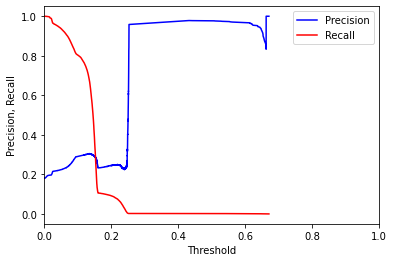

In [72]:
p_curve, r_curve, t_curve = precision_recall_curve(y_val, lr_tuned_val[0][:,1])

plt.plot(t_curve, p_curve[:-1], color="b", label="Precision")
plt.plot(t_curve, r_curve[:-1], color="r", label="Recall")

plt.ylabel("Precision, Recall")
plt.xlabel("Threshold")
plt.xlim([0,1])
plt.legend()

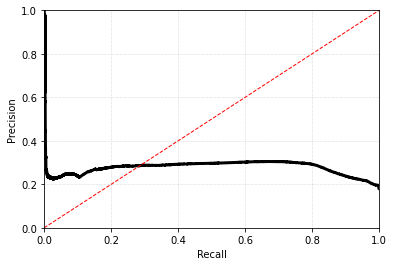

In [73]:
plt.plot(r_curve, p_curve, lw='3', color='black')
plt.plot([0,1], [0,1], color='red', ls='dashed', lw='1')

plt.xlim([0,1])
plt.ylim([0,1])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.grid(ls=':', lw='0.5')

plt.show()

In [74]:
lr_tuned_val[0].shape

(122035, 2)

## ROC Curve and AUC for tuned LogReg model

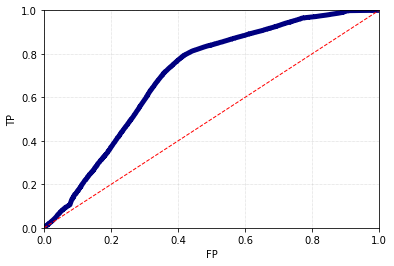

ROC AUC for [Tuned LogReg] model is: 0.7036134606514887


In [75]:
roc_lr_tune = plot_roc('Tuned LogReg', y_val, lr_tuned_val)

In [76]:
# ROC Curve for LogReg

lr_fpr, lr_tpr, lr_thresholds = roc_curve(y_val, lr_val_base[0][:,1])

print(lr_fpr)
print(lr_tpr)
print(lr_thresholds)

[0.         0.         0.         ... 0.99993004 0.99993004 1.        ]
[0.00000000e+00 4.54979753e-05 2.27489877e-04 ... 9.99954502e-01
 1.00000000e+00 1.00000000e+00]
[1.76635519e+00 7.66355187e-01 7.60398431e-01 ... 2.13873458e-09
 3.43387266e-10 2.07329435e-15]


In [87]:
# Setting up ROC Curve for tuned LogReg model
lr_fpr_tr, lr_tpr_tr, lr_thresholds_tr = roc_curve(y_val, lr_tuned_val[0][:,1])

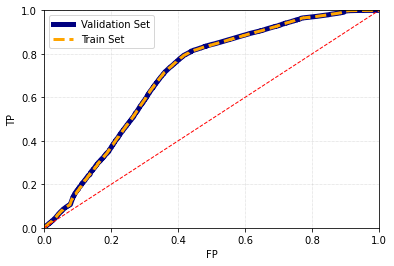

ROC AUC for Validation model is: 0.7036138444394794
ROC AUC for Train set is: 0.705491662402516


In [88]:
plt.plot(lr_fpr, lr_tpr, lw='5', color='navy', label='Validation Set')
plt.plot(lr_fpr_tr, lr_tpr_tr, lw='3', color='orange', ls='--', label='Train Set')

plt.plot([0,1], [0,1], color='red', ls='dashed', lw='1')

plt.xlim([0,1])
plt.ylim([0,1])
plt.xlabel('FP')
plt.ylabel('TP')
plt.grid(ls=':', lw='0.5')
plt.legend()

plt.show()

print(f'ROC AUC for Validation model is: {roc_auc_score(y_val, lr_tuned_val[0][:,1])}')
print(f'ROC AUC for Train set is: {roc_auc_score(y_train, lr_base[0][:,1])}')

meh

## Oversampling the training set

Apply Random Oversampling

In [89]:
print(np.sum((y_train == 1)))
print(np.sum((y_train == 0)))

66456
299646


In [90]:
from imblearn import over_sampling

n_pos = np.sum((y_train == 1))
n_neg = np.sum((y_train == 0))

# Actual dataset contains chargeoff:paidinfull at around 1:5 ratio
# Oversampling the positives(=chargeoffs)
oversample_ratio = {1:n_pos * 4, 0:n_neg}

ROS = over_sampling.RandomOverSampler(sampling_strategy=oversample_ratio, random_state=123)
ROS.fit(X_tr_scale, y_train)
X_tr_ros, y_tr_ros = ROS.fit_resample(X_tr_scale, y_train)

#smt = over_sampling.SMOTE(sampling_strategy='minority', random_state=123)
#smt.fit(X_tr_scale, y_train)
#X_tr_smt, y_tr_smt = smt.fit_resample(X_tr_scale, y_train)

In [91]:
print(np.sum((y_tr_ros == 1)))
print(np.sum((y_tr_ros == 0)))

265824
299646


In [96]:
# Create a new logreg classifier dedicated to oversampled train data
logreg2_ros = LogisticRegression(solver='liblinear', C=0.1, penalty='l1', class_weight={1:1, 0:2}, max_iter=100)

In [97]:
lr_tuned_train_ros = lr_analysis(logreg2_ros, X_tr_ros, y_tr_ros, 'LogReg_ROS_Resample, Train')

Analysis of the Model LogReg_ROS_Resample, Train 
-------------------------------------------------------------------
- Model Score : 0.5409500061895415
- Cost Function: 0.6652444447510992


- Hard classification of the model LogReg_ROS_Resample, Train: [0 0 0 ... 0 0 0]
- Soft classfication of the model LogReg_ROS_Resample, Train: [[0.86066728 0.13933272]
 [0.57497345 0.42502655]
 [0.98309001 0.01690999]
 ...
 [0.59011434 0.40988566]
 [0.56696174 0.43303826]
 [0.60683051 0.39316949]]
--------------------------------------------------------------------------------------------------------------
Classification metrics of the model LogReg_ROS_Resample, Train
- Accuracy:  0.5409500061895415
- Precision:  0.5648400024918496
- Recall:  0.10232710364752619
- F1 Score:  0.17326526127377137


In [98]:
lr_tuned_ros_val = lr_analysis(logreg2_ros, X_val_scale, y_val, 'LogReg_ROS_Resample, Validation')

Analysis of the Model LogReg_ROS_Resample, Validation 
-------------------------------------------------------------------
- Model Score : 0.8202319006842299
- Cost Function: 0.4588473781638278


- Hard classification of the model LogReg_ROS_Resample, Validation: [0 0 0 ... 0 0 0]
- Soft classfication of the model LogReg_ROS_Resample, Validation: [[0.98947521 0.01052479]
 [0.84669024 0.15330976]
 [0.94578243 0.05421757]
 ...
 [0.91154814 0.08845186]
 [0.84684774 0.15315226]
 [0.92201156 0.07798844]]
--------------------------------------------------------------------------------------------------------------
Classification metrics of the model LogReg_ROS_Resample, Validation
- Accuracy:  0.8202319006842299
- Precision:  0.9767441860465116
- Recall:  0.0019109149642840893
- F1 Score:  0.003814367450731087


### Oversampling still yields poor recall and F1 score. So I will move on and try different classifiers.

# B. Random Forest

In [100]:
rf_default = RandomForestClassifier()

In [101]:
rf_n_estimators = [5*i for i in range(8,30, 4)]
rf_weight = ['balanced', {1 : 1, 0 : 2},{1 : 1, 0 : 3},{1 : 1, 0 : 4}, {1 : 1, 0 : 5} ]
max_features = ['log2', 'sqrt', 'auto']  #For some reason 'None' doesnt work
#max_depth = [2,5]
min_samples_split = [2, 4]
min_samples_leaf = [1, 2]
bootstrap = [True, False]


In [103]:
# parameter grid

param_grid_rf = {'n_estimators': rf_n_estimators,
                 'class_weight': rf_weight,
               'max_features': max_features,
#               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

print(param_grid_rf)

{'n_estimators': [40, 60, 80, 100, 120, 140], 'class_weight': ['balanced', {1: 1, 0: 2}, {1: 1, 0: 3}, {1: 1, 0: 4}, {1: 1, 0: 5}], 'max_features': ['log2', 'sqrt', 'auto'], 'min_samples_split': [2, 4], 'min_samples_leaf': [1, 2], 'bootstrap': [True, False]}


In [104]:
rf_Grid = GridSearchCV(estimator = rf_default, param_grid = param_grid_rf, cv = 5, verbose=3, n_jobs = -2)

In [170]:
rf_Grid.fit(X_tr_scale, y_train)

Fitting 5 folds for each of 1440 candidates, totalling 7200 fits


GridSearchCV(cv=5, estimator=RandomForestClassifier(), n_jobs=-2,
             param_grid={'bootstrap': [True, False],
                         'class_weight': ['balanced', {0: 2, 1: 1},
                                          {0: 3, 1: 1}, {0: 4, 1: 1},
                                          {0: 5, 1: 1}],
                         'max_depth': [2, 5],
                         'max_features': ['log2', 'sqrt', 'auto'],
                         'min_samples_leaf': [1, 2],
                         'min_samples_split': [2, 4],
                         'n_estimators': [40, 60, 80, 100, 120, 140]},
             verbose=3)

In [ ]:
rf_Grid.best_params_

{'bootstrap': True,
 'class_weight': {1: 1, 0: 2},
 'max_depth': 2,
 'max_features': 'log2',
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 60}

Interesting class weight...

In [85]:
# With class weight in effect
#rf = RandomForestClassifier(bootstrap=True, max_depth = 5, max_features= 'log2', min_samples_leaf = 1, 
#                            min_samples_split = 2, n_estimators= 40, , class_weight = {1: 1, 0: 2}, random_state=123)
rf = RandomForestClassifier(bootstrap=True, max_features= 'log2', min_samples_leaf = 1, 
                            min_samples_split = 2, n_estimators= 40, class_weight = {1: 1, 0: 2}, random_state=123)

#max_depth=5 is causing some weird problem that reduced recall to near zero, so I will leave it out for now

In [86]:
rf_train = lr_analysis(rf, X_tr_scale, y_train)

Analysis of the Model  
-------------------------------------------------------------------
- Model Score : 0.9257556637221321
- Cost Function: 0.2199303875148896


- Hard classification of the model : [0 0 0 ... 0 0 1]
- Soft classfication of the model : [[0.975      0.025     ]
 [0.92216332 0.07783668]
 [1.         0.        ]
 ...
 [0.82620249 0.17379751]
 [0.83972123 0.16027877]
 [0.175      0.825     ]]
--------------------------------------------------------------------------------------------------------------
Classification metrics of the model 
- Accuracy:  0.9257556637221321
- Precision:  0.9726802262606812
- Recall:  0.6080715059588299
- F1 Score:  0.7483264043851445


In [87]:
rf_val = lr_analysis(rf, X_val_scale, y_val, 'Tuned RF, Validation')

Analysis of the Model Tuned RF, Validation 
-------------------------------------------------------------------
- Model Score : 0.9392633260949728
- Cost Function: 0.19371361972713355


- Hard classification of the model Tuned RF, Validation: [0 0 0 ... 0 1 0]
- Soft classfication of the model Tuned RF, Validation: [[1.         0.        ]
 [0.76214893 0.23785107]
 [1.         0.        ]
 ...
 [1.         0.        ]
 [0.3        0.7       ]
 [0.95000047 0.04999953]]
--------------------------------------------------------------------------------------------------------------
Classification metrics of the model Tuned RF, Validation
- Accuracy:  0.9392633260949728
- Precision:  0.9747115948641074
- Recall:  0.6804222212111561
- F1 Score:  0.8014039976421414


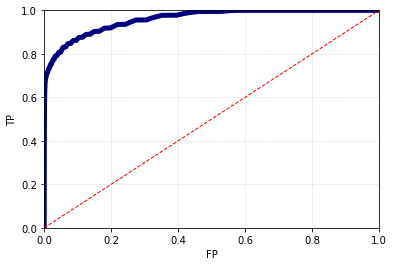

ROC AUC for [Random Forest] model is: 0.9599417985785096


In [88]:
roc_rf = plot_roc('Random Forest', y_val, rf_val)

This looks great, I think I won't bother with ROS set any further, as class weight given in RF seem to do enough job.
<br>Still, let's test out other classifiers.

# C. Naive Bayes

In [111]:
nb = BernoulliNB()

In [112]:
nb.fit(X_tr_scale, y_train)
nb.score(X_tr_scale, y_train)

0.7103867228258791

In [113]:
nb_val = lr_analysis(nb, X_val, y_val)

Analysis of the Model  
-------------------------------------------------------------------
- Model Score : 0.6879010120047527
- Cost Function: 0.48409384018353085


- Hard classification of the model : [0 0 0 ... 0 1 0]
- Soft classfication of the model : [[0.94632359 0.05367641]
 [0.66924662 0.33075338]
 [0.97597634 0.02402366]
 ...
 [0.95245258 0.04754742]
 [0.49942327 0.50057673]
 [0.97597634 0.02402366]]
--------------------------------------------------------------------------------------------------------------
Classification metrics of the model 
- Accuracy:  0.6879010120047527
- Precision:  0.26996458357134695
- Recall:  0.4300468629146003
- F1 Score:  0.33170149672755345


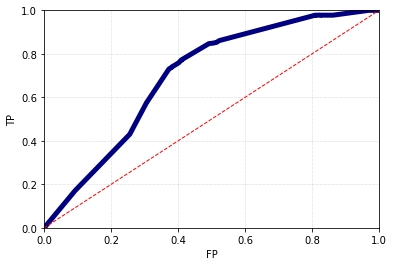

ROC AUC for [NB(Bernoulli) ROC] model is: 0.6982086203071656


In [114]:
roc_nb = plot_roc('NB(Bernoulli) ROC', y_val, nb_val)

# D-1. AdaBoost

In [116]:
ada = AdaBoostClassifier()

In [117]:
ada.fit(X_train, y_train)
ada.score(X_train, y_train)

0.8191105211116028

In [118]:
ada_val = lr_analysis(ada, X_val, y_val)

Analysis of the Model  
-------------------------------------------------------------------
- Model Score : 0.8205268980210595
- Cost Function: 0.6780933835722462


- Hard classification of the model : [0 0 0 ... 0 0 0]
- Soft classfication of the model : [[0.51907338 0.48092662]
 [0.50226333 0.49773667]
 [0.51317967 0.48682033]
 ...
 [0.51269652 0.48730348]
 [0.50437095 0.49562905]
 [0.51317967 0.48682033]]
--------------------------------------------------------------------------------------------------------------
Classification metrics of the model 
- Accuracy:  0.8205268980210595
- Precision:  0.592326139088729
- Recall:  0.01123799990900405
- F1 Score:  0.022057510269691015


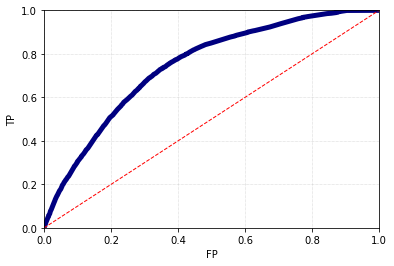

ROC AUC for [AdaBoost ROC] model is: 0.7451726366689315


In [119]:
roc_ada = plot_roc('AdaBoost ROC', y_val, ada_val)

# D-2. XGBoost

In [120]:
xgb = XGBClassifier(use_label_encoder=False)

In [121]:
xgb.fit(X_train, y_train)
xgb.score(X_train, y_train)

[23:32:05] WARNING: D:\bld\xgboost-split_1645118015404\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


0.8254011177212908

In [122]:
xgb_val = lr_analysis(xgb, X_val, y_val)

[23:32:13] WARNING: D:\bld\xgboost-split_1645118015404\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Analysis of the Model  
-------------------------------------------------------------------
- Model Score : 0.8294669562010899
- Cost Function: 0.38043251109040216


- Hard classification of the model : [0 0 0 ... 0 0 0]
- Soft classfication of the model : [[9.9989724e-01 1.0276897e-04]
 [5.6021178e-01 4.3978819e-01]
 [9.2055482e-01 7.9445191e-02]
 ...
 [9.3585283e-01 6.4147152e-02]
 [5.3478104e-01 4.6521896e-01]
 [9.4459176e-01 5.5408251e-02]]
--------------------------------------------------------------------------------------------------------------
Classification metrics of the model 
- Accuracy:  0.8294669562010899
- Precision:  0.6531200839014158
- Recall:  0.11333545657218254
- F1 Score:  0.193

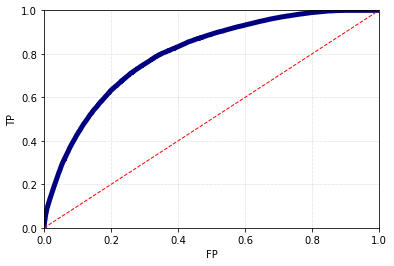

ROC AUC for [XGB ROC] model is: 0.8001598862587722


In [123]:
roc_xgb = plot_roc('XGB ROC', y_val, xgb_val)

# E. Comparison of the models

RandomForest yielded the best result.
I will give a visual comparison among different models with ROC chart below:

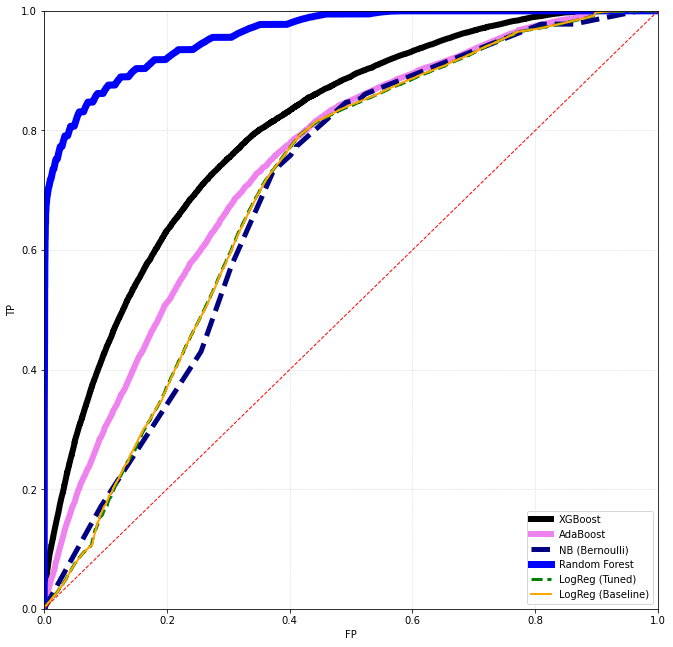

In [90]:
f = plt.figure()
f.set_figwidth(11)
f.set_figheight(11)

plt.plot(roc_xgb[0], roc_xgb[1], lw='6', color='black', label='XGBoost')
plt.plot(roc_ada[0], roc_ada[1], lw='6', color='violet', label='AdaBoost')
plt.plot(roc_nb[0], roc_nb[1], lw='5', color='navy', ls='--', label='NB (Bernoulli)')
plt.plot(roc_rf[0], roc_rf[1], lw='7', color='blue', label='Random Forest')
plt.plot(roc_lr_tune[0], roc_lr_tune[1], lw='3', color='green', ls='--', label='LogReg (Tuned)')
plt.plot(roc_lr_base[0], roc_lr_base[1], lw='2', color='orange', label='LogReg (Baseline)')

plt.plot([0,1], [0,1], color='red', ls='dashed', lw='1')

plt.xlim([0,1])
plt.ylim([0,1])
plt.xlabel('FP')
plt.ylabel('TP')
plt.grid(ls=':', lw='0.5')
plt.legend()


plt.show()

Also, let's compare model scores.

In [91]:
val_model_list = [('Baseline',lr_val_base), ('Tuned LogReg', lr_tuned_val), ('Random Forest', rf_val),
                  ('Naive Bayes(Bernoulli)', nb_val), ('XGBoost', xgb_val), ('AdaBoost', ada_val)]
score_list = []
for i in range(len(val_model_list)):
    print(f'Score of {val_model_list[i][0]} is: {val_model_list[i][1][1]}')
    score_list.append(val_model_list[i][1][1])
    
print('\n')    
for j in range(len(val_model_list)):
    if val_model_list[j][1][1] == max(score_list):
        print(f'The score of the best model [{val_model_list[j][0]}] would be: {max(score_list)}, which is an improvement from baseline score {val_model_list[0][1][1]}')
    else:
        pass

    

Score of Baseline is: 0.8202646781660999
Score of Tuned LogReg is: 0.8202319006842299
Score of Random Forest is: 0.9392633260949728
Score of Naive Bayes(Bernoulli) is: 0.6879010120047527
Score of XGBoost is: 0.8294669562010899
Score of AdaBoost is: 0.8205268980210595


The score of the best model [Random Forest] would be: 0.9392633260949728, which is an improvement from baseline score 0.8202646781660999


#  =================================================


# 3. Testing the Champion Model

In [92]:
rf_test = lr_analysis(rf, X_te_scale, y_test)

Analysis of the Model  
-------------------------------------------------------------------
- Model Score : 0.9385258327528988
- Cost Function: 0.19365116165969376


- Hard classification of the model : [0 0 0 ... 0 0 0]
- Soft classfication of the model : [[1.       0.      ]
 [0.939185 0.060815]
 [0.8      0.2     ]
 ...
 [1.       0.      ]
 [1.       0.      ]
 [0.9      0.1     ]]
--------------------------------------------------------------------------------------------------------------
Classification metrics of the model 
- Accuracy:  0.9385258327528988
- Precision:  0.9704233520201044
- Recall:  0.6813554721078586
- F1 Score:  0.8005953963106693


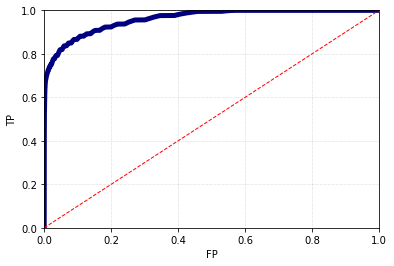

ROC AUC for [Test Dataset with RF] model is: 0.9606761831633712


In [93]:
roc_rf_test = plot_roc('Test Dataset with RF', y_test, rf_test)

# 4. Conclusion - Tuned RandomForest

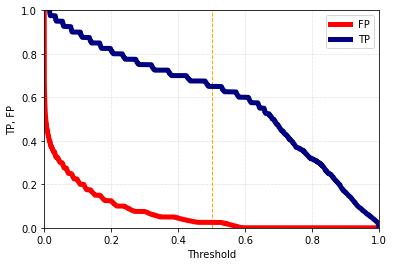

In [94]:
fpr, tpr, thresholds = roc_curve(y_test, rf_test[0][:,1])

plt.plot([0.5,0.5], [0,1], color='orange', ls='dashed', lw='1')
plt.plot(fpr, thresholds, lw='5', color='red', label='FP')
plt.plot(tpr, thresholds, lw='5', color='navy', label='TP')

plt.xlim([0,1])
plt.ylim([0,1])
plt.xlabel('Threshold')
plt.ylabel('TP, FP')
plt.grid(ls=':', lw='0.5')
plt.legend()

plt.show()


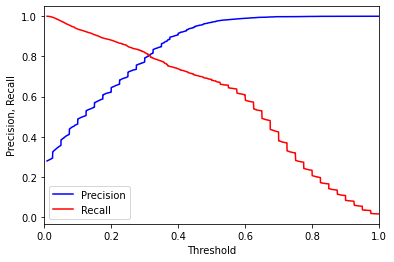

In [95]:
p_curve, r_curve, t_curve = precision_recall_curve(y_test, rf_test[0][:,1])

plt.plot(t_curve, p_curve[:-1], color="b", label="Precision")
plt.plot(t_curve, r_curve[:-1], color="r", label="Recall")

plt.ylabel("Precision, Recall")
plt.xlabel("Threshold")
plt.xlim([0,1])
plt.legend()

If needed, threshold can be tuned via refering to the graph above

In [102]:
# Brute-force tuning threshold from above chart

pred_threshold_tune = (rf_test[0][:,1] >= 0.3133).astype('int')

prec_threshold = precision_score(y_test, pred_threshold_tune)
recall_threshold = recall_score(y_test, pred_threshold_tune)
acc_threshold = accuracy_score(y_test, pred_threshold_tune)
f1_threshold = f1_score(y_test, pred_threshold_tune)

print(acc_threshold)
print(prec_threshold)
print(recall_threshold)
print(f1_threshold)

0.9293973040521162
0.8050391278780477
0.805184816540741
0.8051119656186383


## Confusion Matrix of the Test Set

At the default threshold false positive is quite low, even though recall might suffer somewhat. <br>
Whether or not to apply threshold tuning may be up to interpretaion; for example, SBA might value minimizing wrongfully rejecting loans to eligible businesses than minimizing risky lendings.

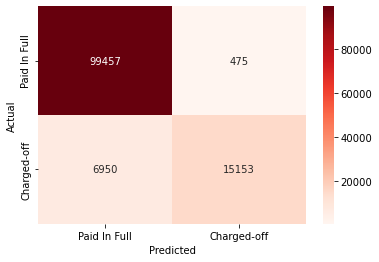

In [101]:
testmodel_cm_maker(rf_test,0.5)

## Evaluating the Improvements Over 'Baseline' Model

In [3]:
metric_comp(lr_val_base, rf_test, 'Default LogReg', 'Tuned Random Forest')

Comparing model score of [Tuned Random Forest] with the base model [Default LogReg] 
------------------------------------------------------------------------------------------------------
ΔScore: 0.11826115458679887
ΔAccuracy: 0.11826115458679887
ΔPrecision: -0.008300052235214683
ΔRecall: 0.6792625652422142
ΔF1: 0.7964185144437848


- Accuracy has increased by about 0.12
- Precision stayed about the same
- Dramatic imporovement was observed in recall (and F1 score as a result)